In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf
from sklearn.metrics import accuracy_score
import model_explain.plot as meplot
# import model_explain.shap as meshap
import tensorflow as tf
from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,LSTM
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

## Load Data 

In [2]:
raw_data = pd.read_csv(os.path.join(root_path, "tweet_dataset.csv"))
data = raw_data[(raw_data.text.isnull()==False) & (raw_data.sentiment != 'empty')].drop_duplicates().reset_index(drop=True)
data['label'] = np.where(data.new_sentiment=='negative',-1,(np.where(data.new_sentiment=='positive',1,0)))
len(data)

39115

In [45]:
data.head(3)

textID   sentiment       author  \
0  1956967666     sadness    wannamama   
1  1956967696     sadness    coolfunky   
2  1956967789  enthusiasm  czareaquino   

                                                text  \
0  Layin n bed with a headache  ughhhh...waitin o...   
1                Funeral ceremony...gloomy friday...   
2               wants to hang out with friends SOON!   

                                            old_text      aux_id  \
0  Layin n bed with a headache  ughhhh...waitin o...  c811396dc2   
1                Funeral ceremony...gloomy friday...  9063631ab1   
2               wants to hang out with friends SOON!  2a815f151d   

  new_sentiment                         selected_text  label  
0      negative                              headache     -1  
1      negative                                gloomy     -1  
2      positive  wants to hang out with friends SOON!      1

In [13]:
i = 175
print(data.text[i])
print("-----------")
# print(data.clean_tweet[i])
print("-----------")
print(data.old_text[i])

  OMG Ur alive!!! LOL  2day has gone sooo slow  I`m going insane Grrr You doing anything tonight?
-----------
-----------
@relly1  OMG Ur alive!!! LOL  2day has gone sooo slow  I'm going insane Grrr You doing anything tonight?


In [3]:
[x for x in data.text]

['Layin n bed with a headache  ughhhh...waitin on your call...',
 'Funeral ceremony...gloomy friday...',
 'wants to hang out with friends SOON!',
 ' We want to trade with someone who has Houston tickets, but no one will.',
 'Re-pinging : why didn`t you go to prom? BC my bf didn`t like my friends',
 'I should be sleep, but im not! thinking about an old friend who I want. but he`s married now. ****, & he wants me 2! scandalous!',
 'Hmmm. http://www.djhero.com/ is down',
 ' Charlene my love. I miss you',
 ' I`m sorry  at least it`s Friday?',
 'cant fall asleep',
 'Choked on her retainers',
 'Ugh! I have to beat this stupid song to get to the next  rude!',
 ' if u watch the hills in london u will realise what tourture it is because were weeks and weeks late  i just watch itonlinelol',
 'Got the news',
 'The storm is here and the electricity is gone',
 ' agreed',
 'So sleepy again and it`s not even that late. I fail once again.',
 ' lady gaga tweeted about not being impressed by her video l

## Explore Data
We run Explore Data in sample dataset.

In [15]:
pos_tweet = list(x.split() for x in data[data['new_sentiment']=='positive']['text'])
neu_tweet = list(x.split() for x in data[data['new_sentiment']=='neutral']['text'])
neg_tweet = list(x.split() for x in data[data['new_sentiment']=='negative']['text'])
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tweet, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tweet, top_n_tokens = 30)
print('top 30 negative review tfidf', negtop10tfidf)
print('top 30 positive review tfidf', postop10tfidf)

top 30 negative review tfidf ['!', 'has', 'Can`t', 'homework', 'really', 'Miss', 'headache', 'sad', 'says', ':/', ':', 'gutted', 'stupid', 'from', 'for', 'find', 'sorry', 'feels', 'feel', 'sounds', 'Friday', 'lame', 'poor', 'hurts', 'Sorry', 'ouch', 'SO', 'RIP', 'BUT', 'missed']
top 30 positive review tfidf ['!', 'makes', 'was', 'I`M', 'In', 'please?', 'Aww', 'perfect', 'LOL', 'thanks', '<3', 'awesome.', 'on', 'nice', 'my', 'Morning', 'morning!', 'Mothers', 'thanks!', 'morning', 'My', 'super', 'Nice', 'I', 'wants', 'rocks', 'Goodmorning', 'Excellent', 'awesome', 'FOR']


In [16]:
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tweet, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tweet, topn = 10)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('to', 3268), ('the', 3091), ('I', 2812), ('a', 2566), ('you', 1791), ('and', 1709), ('my', 1511), ('for', 1455), ('i', 1373), ('is', 1189)]
[('I', 3302), ('to', 3099), ('the', 2524), ('my', 1966), ('a', 1956), ('i', 1719), ('and', 1603), ('is', 1368), ('in', 1144), ('it', 995)]


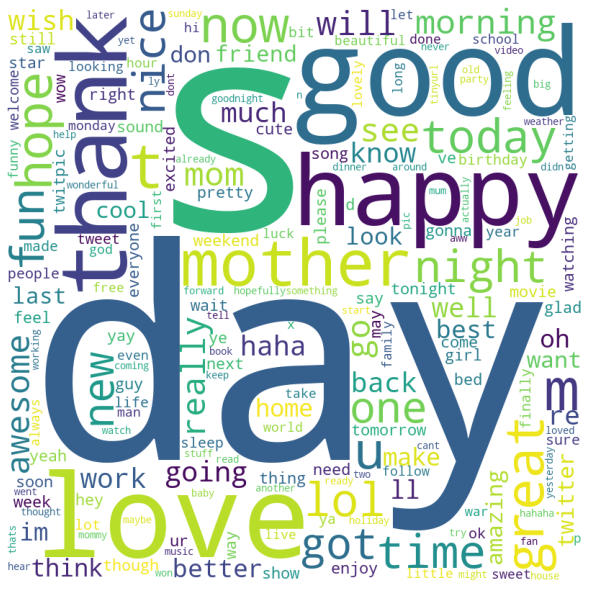

In [17]:
DataExploration.generate_word_cloud(pos_tweet)

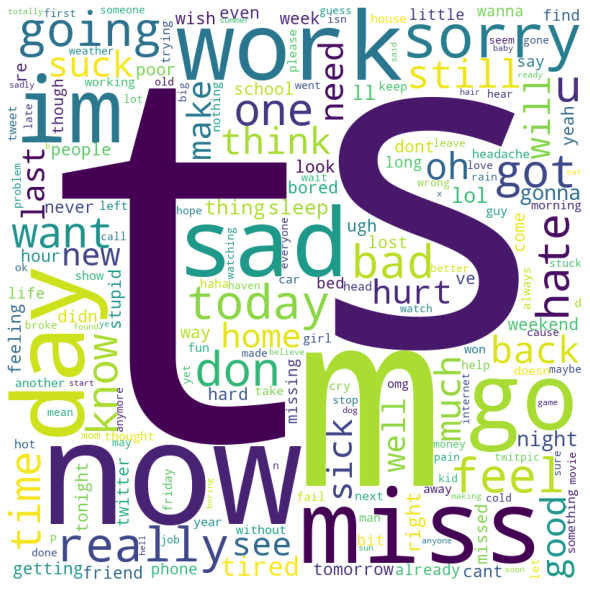

In [18]:
DataExploration.generate_word_cloud(neg_tweet)

We didn't remove stop words, so the LDA does not work well, to do topic modelling, we need to remove stop words. But for sentiment analysis, it is better to keep all words.
However, even for sentiment analysis, we need to set minimal words length, there we need to set it as 2.

In [20]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(pos_tweet, num_topics = no_topics)
lda.lda_topics(lda_allbow)

Topics var1 var2 var3   var4   var5   var6  var7 var8      var9  var10
0       1   to    I   it    the  Happy    you     a  and  Mother`s    I`m
1       2   to  the    I     of     my      a   and  for       you     it
2       3   to  the  you  Happy    and      a   for    i        is     on
3       4    a  and   to     my      I     of  with   is       for    the
4       5  you    a  the     in    day  happy    is  and     great      I
5       6  the    a    I      i   your     to    on  and        in    for
6       7    i    a   to   good    for      -    my    I       and     it
7       8    I   to    a    and    you     so  have  are       the   like
8       9    a    I   my    the    you    for    to  and        it     is
9      10   to  the   my     is      I    all   for   it     Happy  happy

## Prepare training/testing/validation dataset

In [3]:
X = [x for x in data.text]
y = pd.get_dummies(data.label).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 11)

In [93]:
print(y[0:3])
print(data.new_sentiment.head(3))

[[1 0 0]
 [1 0 0]
 [0 0 1]]
0    negative
1    negative
2    positive
Name: new_sentiment, dtype: object


## Word Embedding & RNN

### Glove Word Embedding

In [4]:
# load the whole embedding into memory
embeddings_index = dict()
embedding_dim = 100 
# download glove word embedding first and then load it with the following code
f = open('C:/ProgramData/Anaconda3/append_file/glove/glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close
print('loaded %s word vectors.' % len(embeddings_index))

loaded 400000 word vectors.


In [5]:
max_length = int(np.percentile(data.text.apply(lambda x: len(x.split())), 95))
# we also tried max length, but it cause overfitting

t = Tokenizer()
t.fit_on_texts(X_train)
# print("words with freq:", t.word_docs)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train)
print('Encoding:\n', encoded_docs[0])
print('\nText:\n', list(X_train)[0])
print('\nWord Indices:\n', [(t.index_word[i], i) for i in encoded_docs[0]])
print('vocab size:', vocab_size)
train_padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')


Encoding:
 [92, 2, 3134, 51, 451, 12, 23, 2, 44, 1534]

Text:
 Off to mass, Happy Mum`s day to your mums

Word Indices:
 [('off', 92), ('to', 2), ('mass', 3134), ('happy', 51), ('mum', 451), ('s', 12), ('day', 23), ('to', 2), ('your', 44), ('mums', 1534)]
vocab size: 26698


In [6]:
# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix = zeros((vocab_size, embedding_dim))
for word, idx_word in t.word_index.items():
    word_vector = embeddings_index.get(word)
    if word_vector is not None:
        embedding_matrix[idx_word] = word_vector
print('word:', t.index_word[1])
print('Embedding:\n', embedding_matrix[1])
print('length of embedding matrix is:', len(embedding_matrix))
print('vocabulary size is %s.' % vocab_size)

word: i
Embedding:
 [-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1.43809998  0.99125999
  0.13976     1.34739995 -1.1753      0.0039503   1.02980006  0.064637
  0.90886998  0.82871997 -0.47003001 -0.10575     0.5916     -0.42210001
  0.57331002 -0.54114002  0.10768     0.39783999 -0.048744    0.064596
 -0.61436999 -0.28600001  0.50669998 -0.49757999 -0.81

In [7]:
from scipy.spatial import distance
def find_closest_embeddings(embedding):
    return sorted(embeddings_index.keys(), key = lambda word: distance.euclidean(embeddings_index[word], embedding))
find_closest_embeddings((embedding_matrix[t.word_index['welcome']]))

['welcome',
 'welcoming',
 'welcomed',
 'wish',
 'occasion',
 'inviting',
 'hoped',
 'eager',
 'hoping',
 'opportunity',
 'hope',
 'surprise',
 'invitation',
 'embrace',
 'greet',
 'happy',
 'greeted',
 'promise',
 'come',
 'calling',
 'thank',
 'wishes',
 'praise',
 'invite',
 'delighted',
 'assured',
 'arrival',
 'ready',
 'encouragement',
 'wishing',
 'wished',
 'expect',
 'gesture',
 'call',
 'sort',
 'welcomes',
 'coming',
 'offered',
 'give',
 'pleased',
 '404-222-8268',
 'promised',
 'encouraged',
 'return',
 'urge',
 'wanting',
 'invited',
 'sign',
 'promises',
 'cheer',
 'indeed',
 'thanks',
 'leave',
 'grateful',
 'reminded',
 'enthusiastic',
 'bring',
 'urging',
 'noting',
 'given',
 'supportive',
 'nonetheless',
 'prepared',
 'reception',
 'nod',
 'immediate',
 'moment',
 'celebrate',
 'surely',
 'accept',
 'acceptance',
 'farewell',
 'waiting',
 'delight',
 'hopeful',
 'satisfied',
 'impression',
 'see',
 'certainly',
 'yet',
 'regard',
 'triumphant',
 'promising',
 'genui

In [8]:
encoded_val_doc = t.texts_to_sequences(X_val)
padded_val_doc = pad_sequences(encoded_val_doc, maxlen = max_length, padding = 'post')
encoded_test_doc = t.texts_to_sequences(X_test)
padded_test_doc = pad_sequences(encoded_test_doc, maxlen = max_length, padding = 'post')

In [40]:
padded_val_doc

array([[ 98,   7,   3, ...,   0,   0,   0],
       [  1,  71,   2, ...,   0,   0,   0],
       [679, 690, 486, ...,   0,   0,   0],
       ...,
       [ 98,   1,  42, ...,   0,   0,   0],
       [  6,  19, 904, ...,   0,   0,   0],
       [494,  79, 184, ...,   0,   0,   0]])

### RNN

In [79]:
model = Sequential(
    [
        Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False),
        Flatten(),
        Dense(embedding_dim, activation="relu", name="layer1"),
        Dense(3, activation = 'softmax', name="layer2")
        
    ]
)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 25, 100)           2669800   
_________________________________________________________________
flatten_13 (Flatten)         (None, 2500)              0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               250100    
_________________________________________________________________
layer2 (Dense)               (None, 3)                 303       
Total params: 2,920,203
Trainable params: 250,403
Non-trainable params: 2,669,800
_________________________________________________________________
None


In [80]:
history = model.fit(train_padded_docs, y_train, epochs = 10, verbose = 1, batch_size = 32, validation_data = (padded_val_doc, y_val))

Epoch 1/10
856/856 [==============================] - 2s 2ms/step - loss: 0.9141 - acc: 0.5635 - val_loss: 0.8710 - val_acc: 0.5943
Epoch 2/10
856/856 [==============================] - ETA: 0s - loss: 0.8122 - acc: 0.623 - 1s 2ms/step - loss: 0.8125 - acc: 0.6236 - val_loss: 0.8581 - val_acc: 0.6002
Epoch 3/10
856/856 [==============================] - 1s 2ms/step - loss: 0.7426 - acc: 0.6627 - val_loss: 0.8616 - val_acc: 0.5907
Epoch 4/10
856/856 [==============================] - 1s 2ms/step - loss: 0.6489 - acc: 0.7148 - val_loss: 0.9138 - val_acc: 0.5930
Epoch 5/10
856/856 [==============================] - 1s 2ms/step - loss: 0.5370 - acc: 0.7743 - val_loss: 0.9650 - val_acc: 0.5864
Epoch 6/10
856/856 [==============================] - 1s 2ms/step - loss: 0.4147 - acc: 0.8340 - val_loss: 1.0999 - val_acc: 0.5652
Epoch 7/10
856/856 [==============================] - 1s 2ms/step - loss: 0.3066 - acc: 0.8850 - val_loss: 1.2240 - val_acc: 0.5608
Epoch 8/10
856/856 [==================

In [81]:
acc = history.history['acc']
print ("Accuracy history: ",acc)
val_acc = history.history['val_acc']
print("\nValidation history: ",val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy history:  [0.5635135173797607, 0.6235938668251038, 0.6626734733581543, 0.7147552967071533, 0.7742512822151184, 0.8340394496917725, 0.8850255608558655, 0.9216216206550598, 0.9450693726539612, 0.9616143107414246]

Validation history:  [0.5943251252174377, 0.6002045273780823, 0.5907464027404785, 0.593047022819519, 0.5864008069038391, 0.5651840567588806, 0.5608384609222412, 0.5710633993148804, 0.550613522529602, 0.5493353605270386]


Tried different pre-processing, with more pre-processing, we loss more information, but with raw data we have http web link and @ or #, which are noise, so in the end, we remove the hashtag, userid start with @ and the http link.

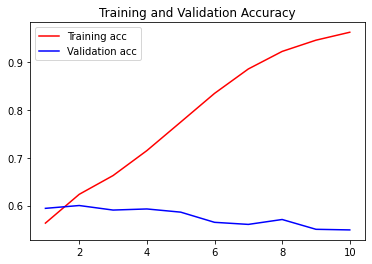

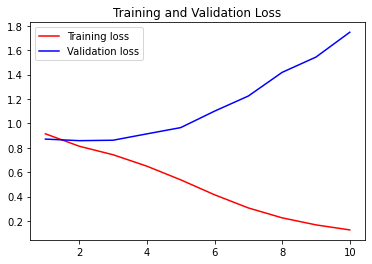

In [82]:
# plot loss rate and accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color = 'r', label = 'Training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'Validation acc')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs, loss, color = 'r', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'b', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [100]:
label_list = [-1,0,1]
pred_test = model.predict(padded_test_doc)
pred_test

array([[4.0552795e-06, 2.3434630e-01, 7.6564962e-01],
       [1.2563337e-02, 9.8739028e-01, 4.6417277e-05],
       [7.3235617e-03, 7.1888357e-01, 2.7379283e-01],
       ...,
       [1.7295600e-06, 9.9573427e-01, 4.2639389e-03],
       [5.4131772e-02, 9.4568807e-01, 1.8016210e-04],
       [9.9960679e-01, 3.9232016e-04, 9.4469522e-07]], dtype=float32)

In [103]:
len([label_list[np.argmax(i)] for i in y_test])
len([label_list[np.argmax(i)] for i in pred_test])

7823

In [104]:
from sklearn.metrics import accuracy_score
accuracy_score([label_list[np.argmax(i)] for i in y_test], [label_list[np.argmax(i)] for i in pred_test])

0.5427585325322766

In [105]:
print(classification_report([label_list[np.argmax(i)] for i in y_test],[label_list[np.argmax(i)] for i in pred_test]))

              precision    recall  f1-score   support

          -1       0.42      0.46      0.44      1685
           0       0.61      0.61      0.61      4171
           1       0.50      0.46      0.48      1967

    accuracy                           0.54      7823
   macro avg       0.51      0.51      0.51      7823
weighted avg       0.54      0.54      0.54      7823



To avoid overfitting, use epochs = 4.

In [106]:
history = model.fit(train_padded_docs, y_train, epochs = 1, verbose = 1, batch_size = 32, validation_data = (padded_val_doc, y_val))

856/856 [==============================] - 2s 2ms/step - loss: 0.1069 - acc: 0.9686 - val_loss: 1.9090 - val_acc: 0.5552


In [107]:
pred_test = model.predict(padded_test_doc)
accuracy_score([label_list[np.argmax(i)] for i in y_test], [label_list[np.argmax(i)] for i in pred_test])

0.5504282244663172

In [108]:
print(classification_report([label_list[np.argmax(i)] for i in y_test],[label_list[np.argmax(i)] for i in pred_test]))

              precision    recall  f1-score   support

          -1       0.45      0.37      0.40      1685
           0       0.61      0.66      0.63      4171
           1       0.48      0.47      0.48      1967

    accuracy                           0.55      7823
   macro avg       0.51      0.50      0.50      7823
weighted avg       0.54      0.55      0.55      7823



### Model Explainability
Reference: https://github.com/slundberg/shap

#### Lime

In [111]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

def predict_for_lime(text_array):
    encoded =t.texts_to_sequences(text_array)
    text_data = pad_sequences(encoded, maxlen=max_length,padding='post')
    pred=model.predict(text_data)
    return pred

# test the predicition function
print ("Verify if predictions are correct for the function")
print(predict_for_lime([X_test[0],X_test[533]]))
print(y_test[0], y_test[533])
#initilaize Lime for text
explainer = LimeTextExplainer(class_names=["Nositive","Neutral","Positive"])

Verify if predictions are correct for the function
[[1.6888303e-05 6.9808923e-02 9.3017411e-01]
 [4.5763355e-07 9.9665391e-01 3.3455719e-03]]
[0 0 1] [0 1 0]


In [112]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[0]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

In [113]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[533]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

### LSTM 

In [11]:
from tensorflow.keras.layers import LSTM
lstm_m = Sequential(
    [
        Embedding(vocab_size, embedding_dim, weights = [embedding_matrix], input_length = max_length, trainable = False, name = 'embedding'),
        LSTM(embedding_dim, dropout=0.2, recurrent_dropout=0.2, name = 'lstm'),
        Dense(3, activation = 'softmax', name="layer2")
        
    ]
)
lstm_m.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(lstm_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           2669800   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
layer2 (Dense)               (None, 3)                 303       
Total params: 2,750,503
Trainable params: 80,703
Non-trainable params: 2,669,800
_________________________________________________________________
None


In [9]:
print(np.__version__) #1.20.2

1.19.2


In [12]:
history = lstm_m.fit(train_padded_docs, y_train, epochs = 10, verbose = 1, batch_size = 32, 
                     validation_data = (padded_val_doc, y_val))


Epoch 1/10
856/856 [==============================] - 21s 21ms/step - loss: 0.8822 - acc: 0.5875 - val_loss: 0.7793 - val_acc: 0.6490
Epoch 2/10
856/856 [==============================] - 17s 20ms/step - loss: 0.7966 - acc: 0.6351 - val_loss: 0.7698 - val_acc: 0.6516
Epoch 3/10
856/856 [==============================] - 17s 20ms/step - loss: 0.7673 - acc: 0.6483 - val_loss: 0.7372 - val_acc: 0.6639
Epoch 4/10
856/856 [==============================] - 17s 20ms/step - loss: 0.7469 - acc: 0.6615 - val_loss: 0.7251 - val_acc: 0.6733
Epoch 5/10
856/856 [==============================] - 17s 20ms/step - loss: 0.7258 - acc: 0.6755 - val_loss: 0.7280 - val_acc: 0.6736
Epoch 6/10
856/856 [==============================] - 17s 20ms/step - loss: 0.7132 - acc: 0.6780 - val_loss: 0.7236 - val_acc: 0.6736
Epoch 7/10
856/856 [==============================] - 17s 20ms/step - loss: 0.6991 - acc: 0.6892 - val_loss: 0.7215 - val_acc: 0.6769
Epoch 8/10
856/856 [==============================] - 17s 20ms

Accuracy history:  [0.5875091552734375, 0.6351351141929626, 0.6482834219932556, 0.6615047454833984, 0.6754565238952637, 0.6780496835708618, 0.6891891956329346, 0.695252001285553, 0.704054057598114, 0.7089115977287292]

Validation history:  [0.6490286588668823, 0.6515848636627197, 0.6638547778129578, 0.6733129024505615, 0.6735684871673584, 0.6735684871673584, 0.6768916249275208, 0.682259738445282, 0.6866053342819214, 0.6868609189987183]


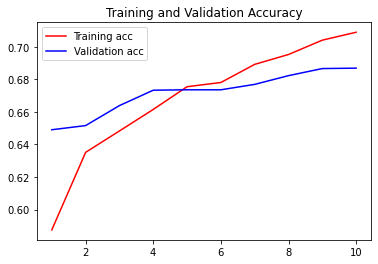

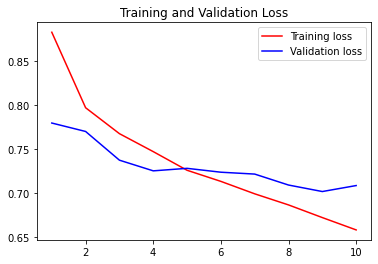

In [13]:
acc = history.history['acc']
print ("Accuracy history: ",acc)
val_acc = history.history['val_acc']
print("\nValidation history: ",val_acc)
loss = history.history['loss']
val_loss = history.history['val_loss']
# plot loss rate and accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, color = 'r', label = 'Training acc')
plt.plot(epochs, val_acc, color = 'b', label = 'Validation acc')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure()
plt.plot(epochs, loss, color = 'r', label = 'Training loss')
plt.plot(epochs, val_loss, color = 'b', label = 'Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [18]:
label_list = [-1,0,1]
pred_test = lstm_m.predict(padded_test_doc)
accuracy_score([label_list[np.argmax(i)] for i in y_test], [label_list[np.argmax(i)] for i in pred_test])

0.6806851591461076

In [22]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

def predict_for_lime(text_array):
    encoded =t.texts_to_sequences(text_array)
    text_data = pad_sequences(encoded, maxlen=max_length,padding='post')
    pred=lstm_m.predict(text_data)
    return pred

# test the predicition function
print ("Verify if predictions are correct for the function")
print(predict_for_lime([X_test[2],X_test[511]]))
print(y_test[2], y_test[511])
#initilaize Lime for text
explainer = LimeTextExplainer(class_names=["Negative","Neutral","Positive"])

Verify if predictions are correct for the function
[[0.00493918 0.2714846  0.7235762 ]
 [0.48387071 0.48151335 0.03461595]]
[0 0 1] [1 0 0]


In [25]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[2]), predict_for_lime, num_features=20, top_labels=1)
exp.show_in_notebook()

In [24]:
#Check explanation for a negative review
exp = explainer.explain_instance(str(X_test[511]), predict_for_lime, num_features=10, top_labels=1)
exp.show_in_notebook()

## DL & Transfer Learning with fastai
some reference:

https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

https://www.kaggle.com/twhelan/covid-19-vaccine-sentiment-analysis-with-fastai


- multivariate classification
- classification with hashtag
- topic modelling with hashtag
- topic modelling 
- word embedding with original text
- classification with pre-trained word embedding (DL)